In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_predict, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
warnings.filterwarnings('ignore')

In [39]:
train = pd.read_csv('Datasets/train.csv', sep='|')

In [4]:
X = train.drop('fraud', 1)
Y = train['fraud'] 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)

In [5]:
#functions
import time
def plotConvergenceRF(epocas):
    n_iter = np.linspace(1, epocas)
    scores = np.array([])
    timeI = time.time()
    for n in n_iter:
        model = RandomForestClassifier(n_estimators=int(n), random_state=0, criterion='entropy').fit(X_train, y_train)
        scores = np.append(scores, model.score(X_test, y_test))

    plt.plot(n_iter, scores)
    plt.xlabel('Number of iterations')
    plt.ylabel('Accuracy')
    plt.show()
    timeF = time.time()
    print("time released: ", round((timeF - timeI)/60, 2))

def scoreModel(model):
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    matrix = confusion_matrix(y_test, y_pred)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))
    print(f"Acuracy: {score*100}%")
    print(f"Score Cup: {weightSum}")
    auc = roc_auc_score(y_test, y_pred, average=None)
    print(f"AUC: {auc*100}%")
    print(f"AUC_prob: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100}%")
    print(f"Confusion matrix: \n{matrix}")

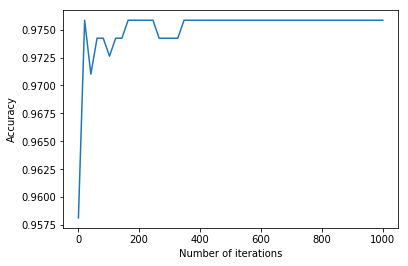

time released:  1.06


In [5]:
plotConvergenceRF(2000)

In [6]:
RF = RandomForestClassifier(n_estimators=1000, random_state=42, criterion='entropy').fit(X_train, y_train)

In [7]:
#holdout - com conjunto de treino e teste estratificados
scoreModel(RF)

Acuracy: 97.58454106280193%
Score Cup: -25
AUC: 82.09740454955406%
AUC_prob: 99.17326385409359%
Confusion matrix: 
[[584   3]
 [ 12  22]]


### Cross-Validation
- Testado para cv=3, 5, 10
- melhores resultados para CV=10

In [79]:
def test_cross_val_predict(k = 3, X_data=X, Y_data=Y):
    clf = RandomForestClassifier(n_estimators=500, random_state=42, criterion='entropy').fit(X_data, Y_data)
    cv = KFold(n_splits=k, random_state=457, shuffle=True)
    y_pred = cross_val_predict(clf, X_data, Y_data, cv=cv)
    matrix = confusion_matrix(Y_data, y_pred)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))
    print(f"Score Cup: {weightSum}")
    auc = roc_auc_score(Y_data, y_pred, average=None)
    print(f"AUC: {auc*100}%")
    print(f"Confusion matrix: \n{matrix}")
def test_cross_val_logistic(k = 3, X_data=X, Y_data = Y):
    clf = LogisticRegressionCV(cv=k, random_state=42).fit(X_data, Y_data)
    y_pred = clf.predict(X_data)
    matrix = confusion_matrix(Y_data, y_pred)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))
    print(f"Score Cup: {weightSum}")
    auc = roc_auc_score(Y_data, y_pred, average=None)
    print(f"AUC: {auc*100}%")
    print(f"Confusion matrix: \n{matrix}")

In [36]:
#crossvalidation cv=3
test_cross_val_predict(3)

Score Cup: -120
AUC: 78.62080173347779%
Confusion matrix: 
[[1767    8]
 [  44   60]]


In [37]:
#crossvalidation cv=5
test_cross_val_predict(5)

Score Cup: -295
AUC: 78.42361863488624%
Confusion matrix: 
[[1760   15]
 [  44   60]]


In [38]:
#crossvalidation cv=10
test_cross_val_predict(10)

# rray([[583,  11],
#        [  9,  18]])

Score Cup: -70
AUC: 83.37215601300109%
Confusion matrix: 
[[1765   10]
 [  34   70]]


### Teste com transformação logaritimica

In [40]:
train_transformed = train
train_transformed['scannedLineItemsPerSecond'] = train['scannedLineItemsPerSecond'].map(lambda x: np.log(x) if x > 0 else 0)
train_transformed['valuePerSecond'] = train['valuePerSecond'].map(lambda x: np.log(x) if x > 0 else 0)
train_transformed['lineItemVoidsPerPosition'] = train['lineItemVoidsPerPosition'].map(lambda x: np.log(x) if x > 0 else 0)
X_log = train_transformed.drop('fraud', 1)

In [41]:
test_cross_val_predict(3, X_log)

Score Cup: -150
AUC: 77.1784940411701%
Confusion matrix: 
[[1767    8]
 [  47   57]]


### Teste com StandardScaler

In [48]:
X_scaled = pd.DataFrame(RobustScaler().fit_transform(X))

In [49]:
test_cross_val_predict(3, X_scaled)

Score Cup: -110
AUC: 79.10157096424703%
Confusion matrix: 
[[1767    8]
 [  43   61]]


In [66]:
test_cross_val_logistic(3, X)

Score Cup: 135
AUC: 92.05417118093175%
Confusion matrix: 
[[1766    9]
 [  16   88]]


### Splitting Data

In [69]:
print('No Frauds', round(train['fraud'].value_counts()[0]/len(train) * 100,2), '% of the dataset')
print('Frauds', round(train['fraud'].value_counts()[1]/len(train) * 100,2), '% of the dataset')

X = train.drop('fraud', axis=1)
y = train['fraud']

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    #print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 94.47 % of the dataset
Frauds 5.53 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.94477711 0.05522289]
[0.94414894 0.05585106]


### Random Under-Sampling

In [114]:
train = train.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = train.loc[train['fraud'] == 1]
non_fraud_df = train.loc[train['fraud'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42).reset_index(drop=True)

new_df.head()

trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  \
0           5                     765       53.32              6   
1           1                     485       17.63             10   
2           1                     996       71.94              7   
3           1                    1783       94.84              3   
4           4                     502       75.97              5   

   scansWithoutRegistration  quantityModifications  scannedLineItemsPerSecond  \
0                        10                      0                  -3.749504   
1                         3                      5                  -2.965273   
2                         0                      1                  -3.607910   
3                         0                      4                  -4.190216   
4                         3                      0                  -3.579543   

   valuePerSecond  lineItemVoidsPerPosition  fraud  
0       -2.663564                 -1.098612      0  
1       -3.314547                 -0.916291      1  
2       -2.627915                 -1.349927      1  
3       -2.933861                 -2.197225      1  
4       -1.888262                 -1.029619      0

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: fraud, dtype: float64


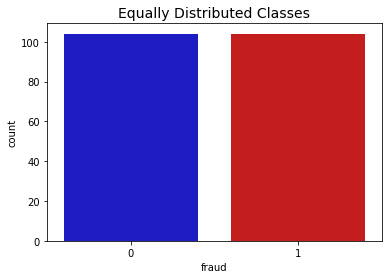

In [115]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['fraud'].value_counts()/len(new_df))
colors = ["#0101DF", "#DF0101"]
sns.countplot('fraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [116]:
test_cross_val_predict(3, new_df.drop('fraud',1), new_df['fraud'])

Score Cup: 290
AUC: 94.71153846153848%
Confusion matrix: 
[[ 96   8]
 [  3 101]]


In [117]:
test_cross_val_logistic(3, new_df.drop('fraud',1), new_df['fraud'])

Score Cup: 400
AUC: 97.11538461538463%
Confusion matrix: 
[[100   4]
 [  2 102]]


#### Correlation Matrix

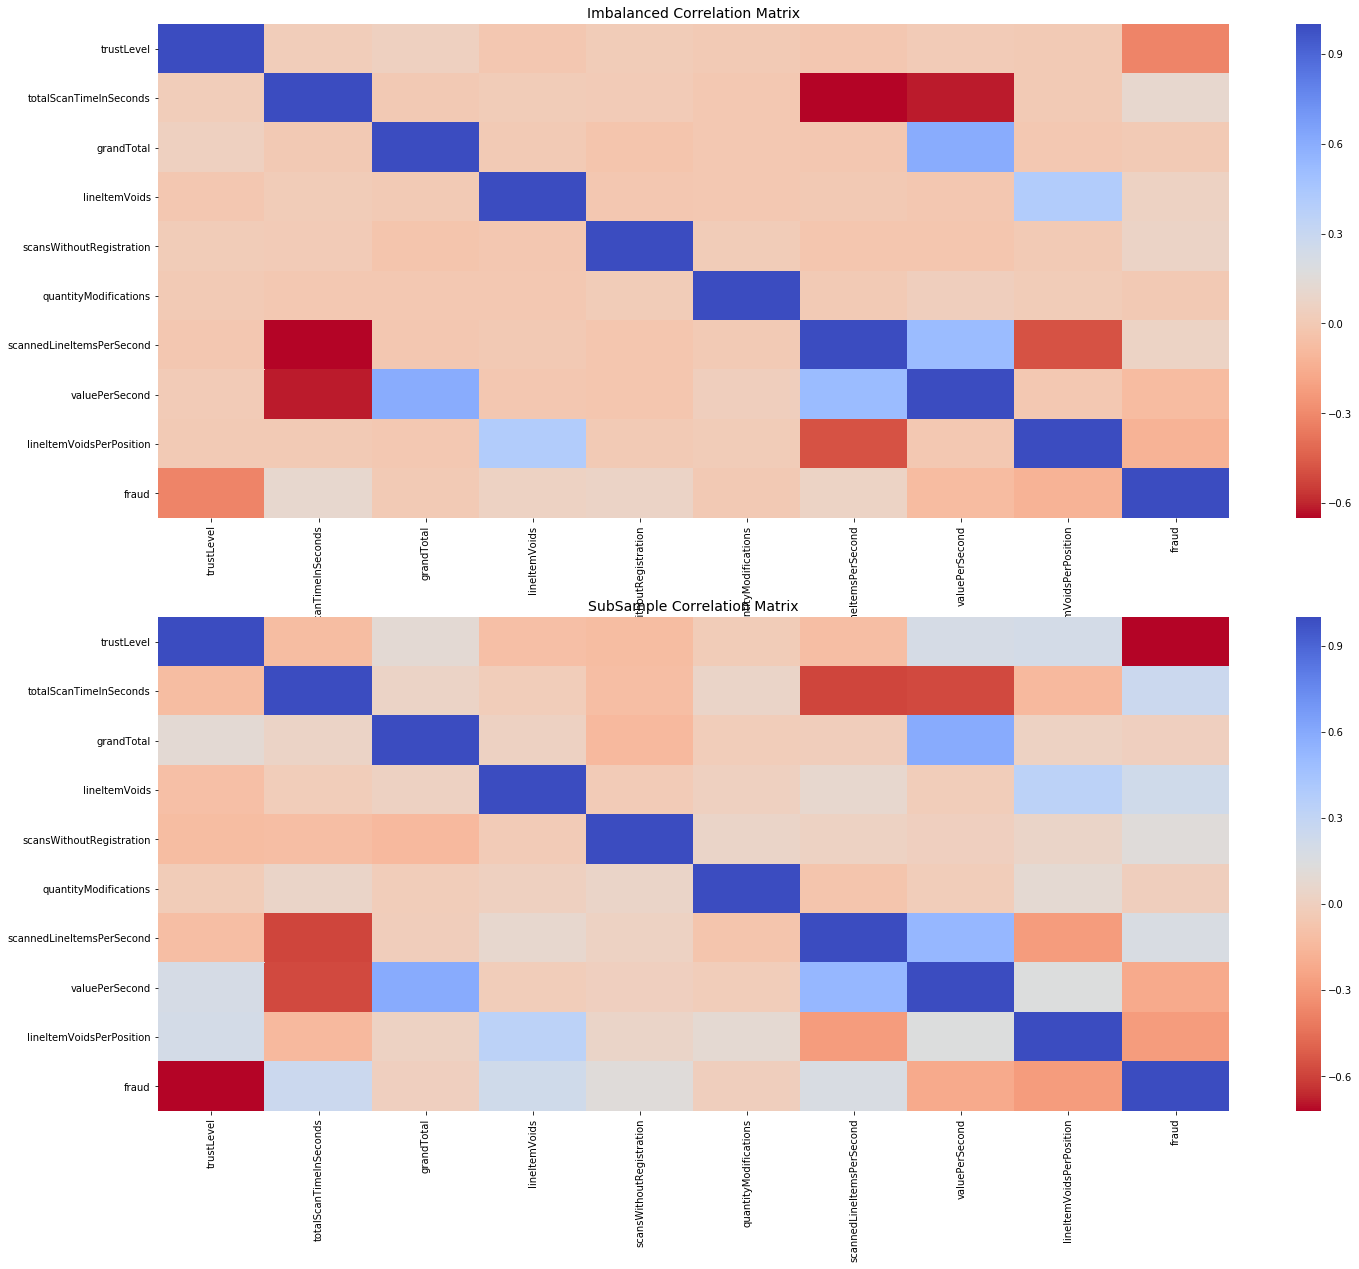

In [118]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

In [119]:
new_df.corr()['fraud']

trustLevel                  -0.721529
totalScanTimeInSeconds       0.251673
grandTotal                  -0.001375
lineItemVoids                0.225737
scansWithoutRegistration     0.121411
quantityModifications       -0.008424
scannedLineItemsPerSecond    0.169272
valuePerSecond              -0.214406
lineItemVoidsPerPosition    -0.284186
fraud                        1.000000
Name: fraud, dtype: float64

- Negative Correlations: trustLevel,valuePerSecond,lineItemVoidsPerPosition.
- Positive Correlations: totalScanTimeInSeconds, lineItemVoids,scansWithoutRegistration, scannedLineItemsPerSecond. 

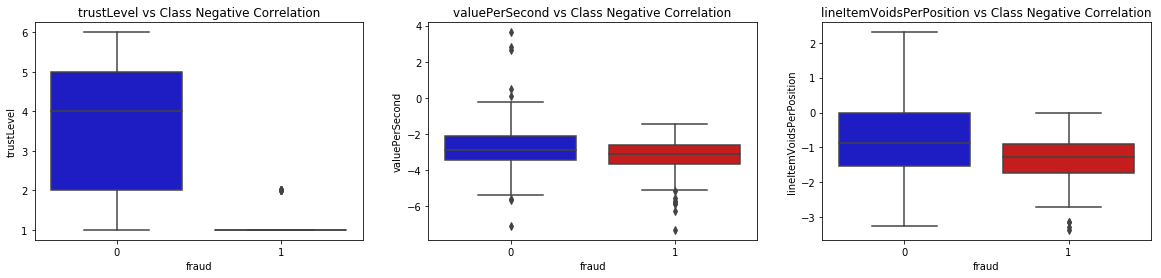

In [120]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))
sns.boxplot(x="fraud", y="trustLevel", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('trustLevel vs Class Negative Correlation')

sns.boxplot(x="fraud", y="valuePerSecond", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('valuePerSecond vs Class Negative Correlation')

sns.boxplot(x="fraud", y="lineItemVoidsPerPosition", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('lineItemVoidsPerPosition vs Class Negative Correlation')

plt.show()


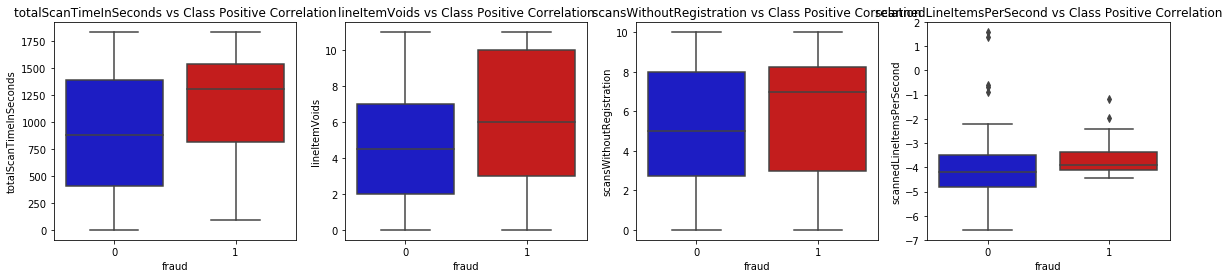

In [121]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="fraud", y="totalScanTimeInSeconds", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('totalScanTimeInSeconds vs Class Positive Correlation')

sns.boxplot(x="fraud", y="lineItemVoids", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('lineItemVoids vs Class Positive Correlation')


sns.boxplot(x="fraud", y="scansWithoutRegistration", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('scansWithoutRegistration vs Class Positive Correlation')


sns.boxplot(x="fraud", y="scannedLineItemsPerSecond", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('scannedLineItemsPerSecond vs Class Positive Correlation')

plt.show()

### Outliers
- Talvez fazer limpeza de outliers por classe

In [165]:
from collections import Counter
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers